In [1]:
import pandas as pd
import numpy as np

responses = pd.read_csv("../datasets/liwc_female_v2_responses.csv")
liwc_vals = pd.read_csv("../datasets/liwc_female_orig_mod_vals.csv")
print(liwc_vals.columns)
print(responses.columns)

Index(['feature Name', 'percentile', 'feature value', 'post_id',
       'y_pred_actual', 'y_pred_orig', 'y_pred_mod', 'Δ', 'liwc_femal_orig',
       'liwc_femal_mod', 'comment', 'post_text'],
      dtype='object')
Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'heartatk', 'consent',
       'scenario_1_action', 'scenario_1_person', 's1t_First Click',
       's1t_Last Click', 's1t_Page Submit', 's1t_Click Count',
       'scenario_2_action', 'scenario_2_person', 's2t_First Click',
       's2t_Last Click', 's2t_Page Submit', 's2t_Click Count',
       'scenario_3_action', 'scenario_3_person', 's3t_First Click',
       's3t_Last Click', 's3t_Page Submit', 's3t_Click Count',
       'scenario_4_action', 'scenario_4_person'

In [2]:
print(responses.shape)

(968, 74)


In [3]:
print(responses['AC'].value_counts())
print(responses['q_3_is_modified'].isna().sum())


1                                                                 861
2                                                                  12
3                                                                  10
4                                                                   2
In this task, you read five passages that all dealt with what?      1
{"ImportId":"QID73"}                                                1
Name: AC, dtype: int64
494


In [4]:
df = responses.loc[(responses["heartatk"] =="4")& (responses["consent"] =="1")]

df_fil = df.dropna(subset=["scenario_1_action", "scenario_2_action", "scenario_3_action", "scenario_4_action", "scenario_5_action"])
df_fil = df_fil.dropna(subset=["scenario_1_person", "scenario_2_person", "scenario_3_person", "scenario_4_person", "scenario_5_person"])
df_fil = df_fil.dropna(subset=["q_1_id", "q_2_id", "q_3_id", "q_4_id", "q_5_id"])
print(df.shape)
colMax = {1: {"action":df_fil["scenario_1_action"].astype("int").max(), "person":df_fil["scenario_1_person"].astype("int").max()}, 2: {"action":df_fil["scenario_2_action"].astype("int").max(), "person":df_fil["scenario_2_person"].astype("int").max()}, 3: {"action":df_fil["scenario_3_action"].astype("int").max(), "person":df_fil["scenario_3_person"].astype("int").max()}, 4: {"action":df_fil["scenario_4_action"].astype("int").max(), "person":df_fil["scenario_4_person"].astype("int").max()}, 5: {"action":df_fil["scenario_5_action"].astype("int").max(), "person":df_fil["scenario_5_person"].astype("int").max()}, }
colMin = {1: {"action":df_fil["scenario_1_action"].astype("int").min(), "person":df_fil["scenario_1_person"].astype("int").min()}, 2: {"action":df_fil["scenario_2_action"].astype("int").min(), "person":df_fil["scenario_2_person"].astype("int").min()}, 3: {"action":df_fil["scenario_3_action"].astype("int").min(), "person":df_fil["scenario_3_person"].astype("int").min()}, 4: {"action":df_fil["scenario_4_action"].astype("int").min(), "person":df_fil["scenario_4_person"].astype("int").min()}, 5: {"action":df_fil["scenario_5_action"].astype("int").min(), "person":df_fil["scenario_5_person"].astype("int").min()}, }
print(colMax)
print(colMin)

(956, 74)
{1: {'action': 46, 'person': 44}, 2: {'action': 39, 'person': 37}, 3: {'action': 39, 'person': 37}, 4: {'action': 39, 'person': 37}, 5: {'action': 39, 'person': 37}}
{1: {'action': 40, 'person': 38}, 2: {'action': 33, 'person': 31}, 3: {'action': 33, 'person': 31}, 4: {'action': 33, 'person': 31}, 5: {'action': 33, 'person': 31}}


In [5]:
print(df['scenario_1_action'].value_counts())
print(df.shape)

40    349
41    137
46    102
44    100
43     96
42     91
45     42
Name: scenario_1_action, dtype: int64
(956, 74)


In [6]:
import math
def recodeValues(columnIdx, isAction, value):
    if str(value).strip().lower()=="nan":
        return None
    value = int(value)
    return value - colMin[columnIdx]["action" if isAction else "person"] +1
    
def getLiwcVals(type, id):
    col = "liwc_femal_orig" if type == "orig" else "liwc_femal_mod"
    print(id)
    to_ret =liwc_vals.loc[liwc_vals["post_id"]==id][col].item()
    return float(to_ret)
    
new_format =[]
# New format is: id, is_modified, answer_action,answer_person
badEntryCounter=0
for index, row in df.iterrows():
    dmy = str(row["gender"]).strip().lower()
    gender = None
    if dmy == "4":
        gender =1
    elif dmy=="5":
        gender = -1
    elif dmy=="6":
        gender = 2
    elif dmy=="7":
        gender=3
    else:
        badEntryCounter+=1

    for i in range(1,6):
        r_id = row[f"q_{i}_id"]
        if type(r_id) == float and math.isnan(r_id):
            badEntryCounter+=1
            #not sure if bad entry counter is correct or should be diveded by 4
            continue
       
        r_isMod = 1 if row[f"q_{i}_is_modified"] == "true" else -1
        r_action =  recodeValues(i, True, row[f"scenario_{i}_action"])
        r_person = recodeValues(i, False, row[f"scenario_{i}_person"])
        r_age = None if str(row["age"]).strip().lower() == "nan" else int(row["age"])
        r_gender = gender
        r_responseId = row["ResponseId"]
        r_ac = row["AC"]
        r_liwcOrig = getLiwcVals("orig", r_id)
        r_liwcMod = getLiwcVals("modified", r_id)
        
        r_i = [r_id, r_isMod, r_action, r_person, r_age, r_gender, r_responseId, r_ac, r_liwcOrig, r_liwcMod ]
        new_format.append(r_i)


print("NAN values:",badEntryCounter)
df_new_format = pd.DataFrame(np.array(new_format), columns=['scenarioId', 'isModified', 'scenarioAction', 'scenarioPerson', "age", "gender", "responseId", "acResponse", "liwcOriginal", "liwcModified"], )
df_new_format["isModified"] = df_new_format["isModified"].astype("Int64")
df_new_format["scenarioAction"] = df_new_format["scenarioAction"].astype("Int64")
df_new_format["scenarioPerson"] = df_new_format["scenarioPerson"].astype("Int64")
df_new_format["gender"] = df_new_format["gender"].astype("Int64")
df_new_format["age"] = df_new_format["age"].astype("Int64")
df_new_format["liwcOriginal"] = df_new_format["liwcOriginal"].astype("Float64")
df_new_format["liwcModified"] = df_new_format["liwcModified"].astype("Float64")

print("TRANSFORMED OUTPUT STILL CONTAINS ATTENTION CHECK")

bu2kf5
bu2kf5
2
hql2q4
hql2q4
2
ggyb2v
ggyb2v
2
b1cbcz
b1cbcz
2
gcmhy1
gcmhy1
2
ggyb2v
ggyb2v
1
b1cbcz
b1cbcz
1
bd0ww1
bd0ww1
1
cjudzm
cjudzm
1
hv6xro
hv6xro
1
cjudzm
cjudzm
1
bd0ww1
bd0ww1
1
b6uiz7
b6uiz7
1
eq3k7y
eq3k7y
1
mj8a47
mj8a47
1
cmkl5l
cmkl5l
1
bs50ps
bs50ps
1
b1cbcz
b1cbcz
1
eq3k7y
eq3k7y
1
gcti52
gcti52
1
eq3k7y
eq3k7y
1
bt8mm5
bt8mm5
1
bu2kf5
bu2kf5
1
mj8a47
mj8a47
1
b6uiz7
b6uiz7
1
eq3k7y
eq3k7y
1
mj8a47
mj8a47
1
bs50ps
bs50ps
1
gcmhy1
gcmhy1
1
kcf1e0
kcf1e0
1
gcmhy1
gcmhy1
1
cmkl5l
cmkl5l
1
mj8a47
mj8a47
1
b6uiz7
b6uiz7
1
eq3k7y
eq3k7y
1
mj8a47
mj8a47
1
blexov
blexov
1
gcti52
gcti52
1
j0do3l
j0do3l
1
b1cbcz
b1cbcz
1
aos6vn
aos6vn
1
eq3k7y
eq3k7y
1
bd0ww1
bd0ww1
1
mj8a47
mj8a47
1
gcti52
gcti52
1
hql2q4
hql2q4
1
kcf1e0
kcf1e0
1
cmkl5l
cmkl5l
1
j0do3l
j0do3l
1
eq3k7y
eq3k7y
1
eq3k7y
eq3k7y
1
kcf1e0
kcf1e0
1
mj8a47
mj8a47
1
bs50ps
bs50ps
1
gcmhy1
gcmhy1
1
hql2q4
hql2q4
1
gcmhy1
gcmhy1
1
bd0ww1
bd0ww1
1
kcf1e0
kcf1e0
1
b1cbcz
b1cbcz
1
b1cbcz
b1cbcz
2
blexov
blexov
2
j0do3l
j

In [25]:
print(df_new_format.shape)
print(df_new_format.dtypes)

(4775, 10)
scenarioId         object
isModified          Int64
scenarioAction      Int64
scenarioPerson      Int64
age                 Int64
gender              Int64
responseId         object
acResponse         object
liwcOriginal      Float64
liwcModified      Float64
dtype: object


In [26]:
print(df_new_format['scenarioPerson'].value_counts())
print(df_new_format["liwcOriginal"].head(10))
print(df_new_format.isna().sum())
print(df_new_format.isin(['nan']).sum(axis=0))

4    1196
1    1001
2     702
3     640
5     433
6     271
7     256
Name: scenarioPerson, dtype: Int64
0    17.06
1    19.23
2    14.71
3    15.63
4     3.19
5    14.71
6    15.63
7     8.29
8    19.39
9    13.19
Name: liwcOriginal, dtype: Float64
scenarioId          0
isModified          0
scenarioAction    276
scenarioPerson    276
age               375
gender            375
responseId          0
acResponse        355
liwcOriginal        0
liwcModified        0
dtype: int64
scenarioId        0
isModified        0
scenarioAction    0
scenarioPerson    0
age               0
gender            0
responseId        0
acResponse        0
liwcOriginal      0
liwcModified      0
dtype: int64


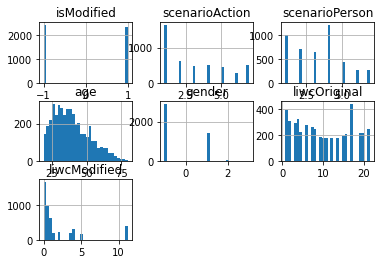

In [27]:
hist = df_new_format.hist(bins=30)

In [28]:
df_new_format.to_excel("aita_data_transformed.xlsx", index=False)